In [18]:
import sys

sys.path.append('C:/Users/nilso/Documents/EPFL/PDM/PDM_PINN/SciANN/DNN_TEST/sys/')

from loss import *
from unet import UNet
from dataloader import *
from BaseModel import BaseModel

import matplotlib.pyplot as plt

import torch.optim as optim
import time
import logging

In [19]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

In [20]:
training_data = dataset('../../Simple_Homogeneous_Moseley/','../../Simple_Homogeneous_Moseley_Event0000_Continuous.csv')

In [13]:
# # # Training
train_loader = DataLoader(training_data, batch_size=2, shuffle=True)

net = UNet(in_channels=4,out_channels=1)

In [14]:
class UNetModel(BaseModel):
    def __init__(self, net, opt=None, sched=None, logger=None, print_progress=True, device='cpu'):
        """

        """
        super().__init__(net, opt, sched, logger, print_progress, device)

        self.loss_fn = MSLoss(*[nn.MSELoss(),PINNLoss()])


    def forward_loss(self, data):
        """

        """
        input, label = data['wave_input'].transpose(2, 1) , data['wave_output'].transpose(2, 1)
        input = input.to(self.device)
        label = label.to(self.device)

        output = self.net(input)
        loss = self.loss_fn(output, label)

        return loss[0], {'Loss':loss[0],'Loss MSE':loss[1],'PINN GDL':loss[2]}

## Testing

In [15]:
model = UNetModel(net, device='cpu')
model.load(import_path='results/L2_PINN_E500.pt',map_location='cpu')

In [16]:
# # # Testing - One sample
time_step = 10

test_sample = training_data.__getitem__(time_step)

test_x = test_sample['wave_input'].transpose(1, 0)
test_x = test_x.to('cpu')
model.net = model.net.to('cpu')

test_gen = model.net(test_x[None])

test_gt = test_sample['wave_output'].transpose(1, 0)[None]

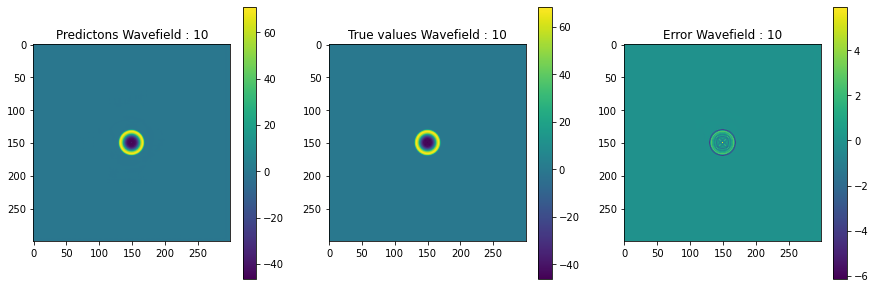

In [17]:
# # # Plot Testing - One Sample

pred = test_gen[0,0].detach().cpu().numpy()
true = test_gt[0,0].detach().cpu().numpy()
error = pred - true

fig , ax = plt.subplots(1,3,figsize=(15,5))
im = ax[0].imshow(pred)
ax[0].set_title(f'Predictons Wavefield : {time_step}')
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(true)
ax[1].set_title(f'True values Wavefield : {time_step}')
plt.colorbar(im, ax=ax[1])
im = ax[2].imshow(error)
ax[2].set_title(f'Error Wavefield : {time_step}')
plt.colorbar(im, ax=ax[2])

In [36]:
# # # Testing - Recursive Testing

# Parameters
initial_timestep = 20
number_of_timestep_to_predict = 170
timestep_to_plot = [0,25,50,100,150]

# Inputs
initial_test_sample = training_data.__getitem__(initial_timestep)
test_x = initial_test_sample['wave_input'].transpose(1, 0)[None]
test_x = test_x.to('cpu')

model.net = model.net.to('cpu')

# Store the outputs
preds = np.zeros((len(timestep_to_plot),300,300))
trues = np.zeros((len(timestep_to_plot),300,300))
norms = []

start_time = time.time()

im = 0
for ts in range(number_of_timestep_to_predict):

    # Predicted wavefield
    test_gen = model.net(test_x)
    pred = test_gen[0,0].detach().cpu().numpy()

    # True wavefield
    test_gt = training_data.__getitem__(initial_timestep+ts)['wave_output'].transpose(1, 0)[None]
    true = test_gt[0,0].detach().cpu().numpy()

    # Store selected wavefield
    if ts in timestep_to_plot:
        print(f"Saving wavefield {ts}")
        preds[im,:,:] = pred
        trues[im,:,:] = true
        im += 1

    # Update wavefield
    test_x = torch.cat((test_x,test_gen),dim=1)[:,1:,:,:] # Concat gen wavefield as the new input wavefield

    # Save norm
    norms.append(np.linalg.norm(true-pred))
end_time = time.time()

total_time = end_time - start_time

print(f'\nTotal time for the predictions [s] for {number_of_timestep_to_predict} timesteps :',np.round(total_time,2))

errors = preds - trues

Saving wavefield 0
Saving wavefield 25
Saving wavefield 50
Saving wavefield 100
Saving wavefield 150

Total time for the predictions [s] for 170 timesteps : 205.15


In [37]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

Text(0.5, 0.98, 'Initital timestep : 20')

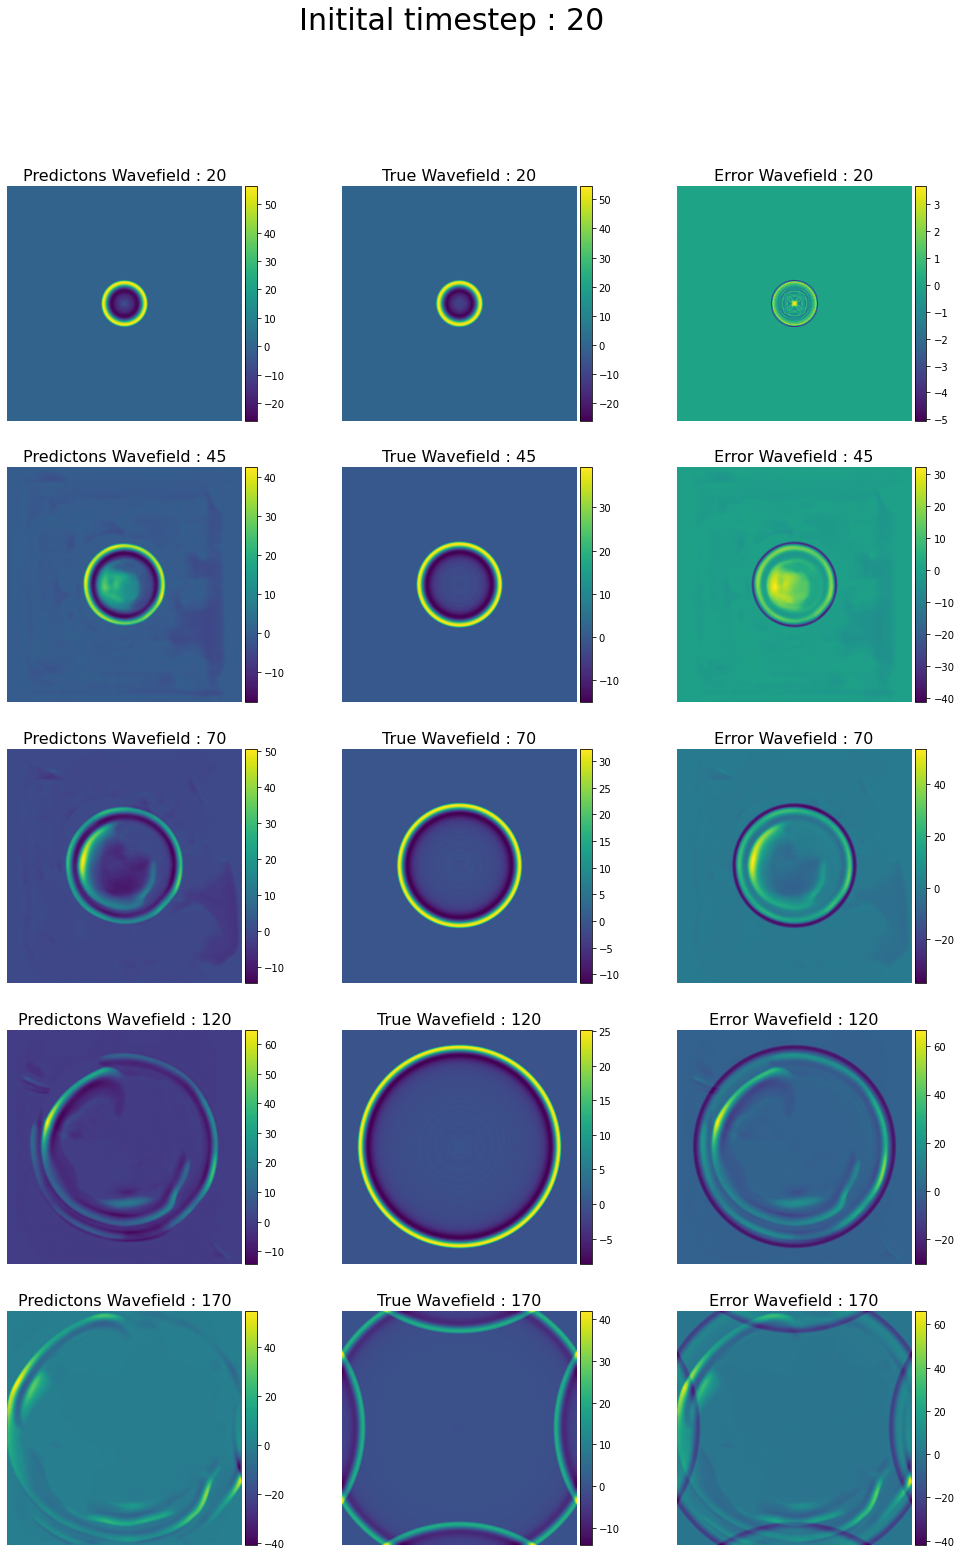

In [38]:
# # # Plot testing - multiple sample

fig , axs = plt.subplots(len(timestep_to_plot),3,figsize=(17,len(timestep_to_plot)*5))

for row, ts in enumerate(timestep_to_plot):

    im = axs[row,0].imshow(preds[row,:,:])

    divider = make_axes_locatable(axs[row,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axs[row,0].axis('off')
    axs[row,0].set_title(f'Predictons Wavefield : {initial_timestep + ts}',fontsize=16)

    im = axs[row,1].imshow(trues[row,:,:])

    divider = make_axes_locatable(axs[row,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axs[row,1].axis('off')
    axs[row,1].set_title(f'True Wavefield : {initial_timestep + ts}',fontsize=16)

    im = axs[row,2].imshow(errors[row,:,:])

    divider = make_axes_locatable(axs[row,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axs[row,2].axis('off')
    axs[row,2].set_title(f'Error Wavefield : {initial_timestep + ts}',fontsize=16)

fig.suptitle(f'Initital timestep : {initial_timestep}', fontsize=30)

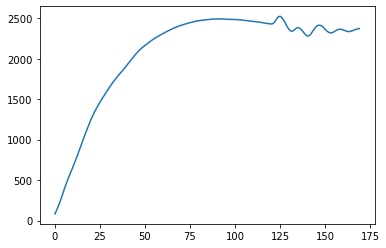

In [39]:
plt.plot(norms)

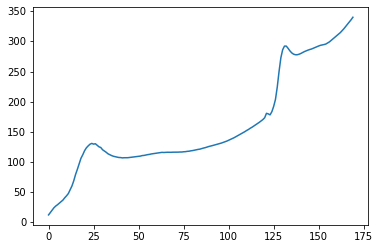

In [17]:
plt.plot(norms)

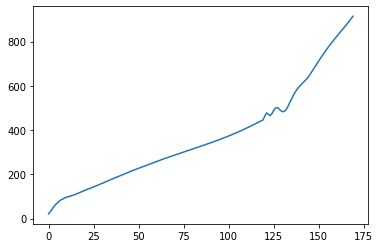

In [47]:
plt.plot(norms)

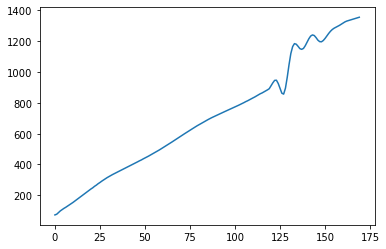

In [40]:
plt.plot(norms)

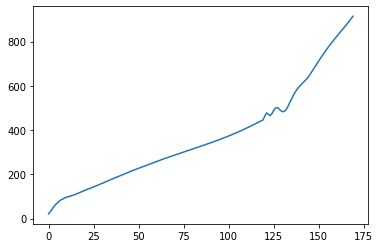

In [28]:
plt.plot(norms)

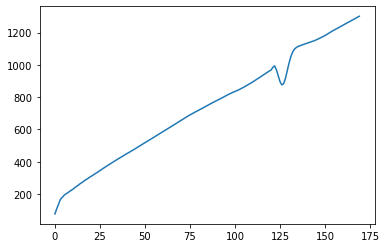

In [21]:
plt.plot(norms)

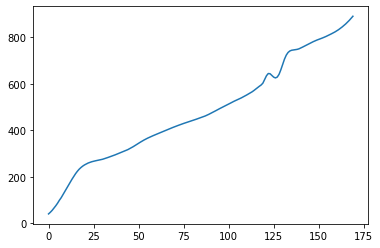

In [14]:
plt.plot(norms)